# 为“音色分离转录”任务创建数据集

In [1]:
import os
from gen import Notes
import numpy as np
import torchaudio
import sys
sys.path.append('..')
from fluidsynth import Synth
sys.path.append('../..')
from utils.midiarray import numpy2midi, midi_randomize
from utils.wavtool import cutWave
from model.CQT import CQTsmall_fir
from model.layers import EnergyNorm

Fluidsynth library loaded.


In [2]:
# 总文件夹
output_dir = 'small_256'

# 基本配置
instrument = [
    [0, 4, 7, 24, 25, 27],# 击弦
    [72, 73, 74, 76],# 木管(长笛)
    [64, 65, 66],# 萨克斯
    [40, 41, 42, 48],# 弓弦
    [68, 69],# 双簧
    [20, 21, 22, 23],# 自由簧
    [52, 53, 54],# 人声
    [56, 57, 61],# 铜管 号
    [98, 8],# 敲钟
    [71, 80, 111]# 不知道分哪里
]
midi_num = 12
octave_weight = [1, 3, 5, 5, 5, 3, 2]
frames = 600

do_CQT = True
# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame
piece_len = frames * s_per_frame
print(s_per_frame, piece_len)
np.random.seed(3407)    # 《Torch.manual_seed(3407) is all you need》

0.011609977324263039 6.965986394557823


In [2]:
# 总文件夹
output_dir = 'tiny_256'

# 基本配置
instrument = [
    [1, 2], # 钢琴
    75, # 木管
    67, # 萨克斯
    68, # 双簧管
    71, # 单簧管 比较独特
    41, # 弓弦
    21, # 自由簧
    85, # 人声
    59  # 铜管
]
midi_num = 4
octave_weight = [1, 3, 5, 5, 5, 3, 1]
frames = 600

do_CQT = True
# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame
piece_len = frames * s_per_frame
print(s_per_frame, piece_len)
np.random.seed(114514)

0.011609977324263039 6.965986394557823


In [3]:
generator = Notes(
    octave_weight = octave_weight,
    len_range = (4, 100),
    len_mean = 32,
    len_sigma = -1,
    offset_mean = 0
)
s = Synth(CONFIG.CQT.fs, gain = 0.7)
cqt = CQTsmall_fir(
    False,
    False,
    config=CONFIG.CQT
)
norm = EnergyNorm(output_type=0)

In [4]:
# 乐器分类
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for inst in instrument:
    if isinstance(inst, list):
        inst_folder_name = "_".join(map(str, inst))
    else:
        inst_folder_name = str(inst)
        inst = [inst]
    sub_dir = os.path.join(output_dir, f"inst{inst_folder_name}")
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)

    for midi_id in range(midi_num):
        np_name = os.path.join(sub_dir, f"{midi_id}.npy")
        midi_name = os.path.join(sub_dir, f"{midi_id}.mid")
        wav_name = os.path.join(sub_dir, f"{midi_id}.wav")

        np_midi = generator.generate(frames, 0.18, 0.53)
        np.save(np_name, np_midi)
        midi_randomize(
            numpy2midi(np_midi, s_per_frame, time_first=False, random=True, instrument=inst[midi_id % len(inst)]),
            velocity_range=(46, 127),
            pitch_range=(-1000, 1000),
        ).save(midi_name)
        s.midi2audio(midi_name, wav_name)
        if do_CQT:
            # 生成CQT
            cqt_name = os.path.join(sub_dir, f"{midi_id}.cqt.npy")
            waveform, sample_rate = torchaudio.load(wav_name, normalize=True)
            waveform = waveform.unsqueeze(0)    # 增加batch维
            cqt_data = norm(cqt(waveform)).squeeze(0).numpy() # 去掉batch维 [2, 288, time]
            np.save(cqt_name, cqt_data[:, :, :frames])  # 截取前frames帧
        # 剪裁音频
        cutWave(wav_name, wav_name, 0, piece_len, mono=True)

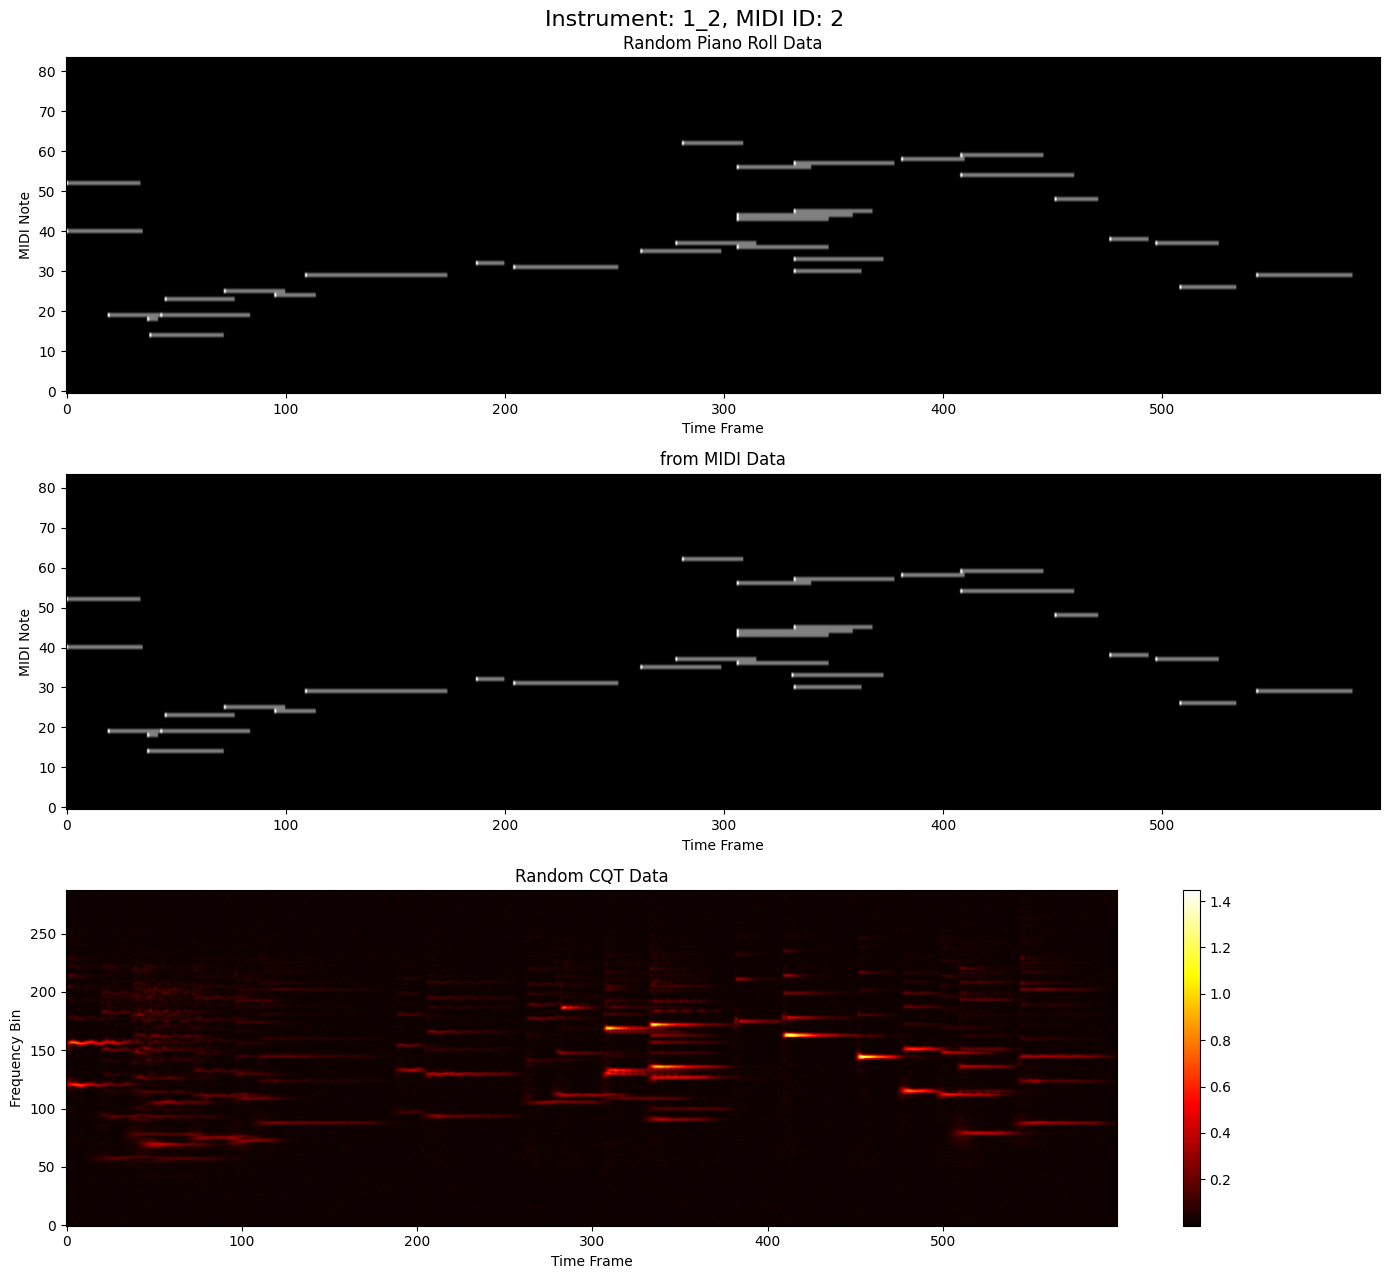

In [ ]:
# 观察数据（有CQT的版本）
import matplotlib.pyplot as plt
from utils.midiarray import midi2numpy
import numpy as np

instrument_folder_name = ["_".join(map(str, inst)) for inst in instrument if isinstance(inst, list) ] + [str(inst) for inst in instrument if not isinstance(inst, list)]

# 随机选择一个乐器和序号
random_inst = np.random.choice(instrument_folder_name)
random_midi_id = np.random.randint(midi_num)

# 打开对应的npy文件
random_np_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.npy")
random_np_midi = np.load(random_np_name)

random_cqt_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.cqt.npy")
random_cqt = np.load(random_cqt_name)
noise = np.random.normal(0, 1, random_cqt.shape) * 0.01 # 测试加噪水平
random_cqt += noise
random_cqt = np.sqrt(random_cqt[0]**2 + random_cqt[1]**2)

random_midi_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.mid")
frommidi = midi2numpy(random_midi_name, s_per_frame)
if frommidi.shape[1] < frames:
    padding = np.zeros((frommidi.shape[0], frames - frommidi.shape[1]))
    frommidi = np.hstack((frommidi, padding))
else:
    frommidi = frommidi[:, :frames]

# 设置总标题
plt.figure(figsize=(14, 38))
plt.suptitle(f'Instrument: {random_inst}, MIDI ID: {random_midi_id}', fontsize=16)

# 绘制random_np_midi
plt.subplot(3, 1, 1)
plt.imshow(random_np_midi, aspect='auto', origin='lower', cmap='gray')
plt.title('Random Piano Roll Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

plt.subplot(3, 1, 2)
plt.imshow(frommidi, aspect='auto', origin='lower', cmap='gray')
plt.title('from MIDI Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

# 绘制random_cqt
plt.subplot(3, 1, 3)
plt.imshow(random_cqt, aspect='auto', origin='lower', cmap='hot')
plt.title('Random CQT Data')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.gcf().set_size_inches(14, 13)  # 设置图像大小
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# 没有CQT的可视化
# 观察数据
import matplotlib.pyplot as plt
from utils.midiarray import midi2numpy
import numpy as np

if isinstance(instrument[0], list):
    instrument_folder_name = ["_".join(map(str, inst)) for inst in instrument]
else:
    instrument_folder_name = [str(inst) for inst in instrument]
# 随机选择一个乐器和序号
random_inst = np.random.choice(instrument_folder_name)
random_midi_id = np.random.randint(midi_num)

# 打开对应的npy文件
random_np_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.npy")
random_np_midi = np.load(random_np_name)

random_midi_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.mid")
frommidi = midi2numpy(random_midi_name, s_per_frame)
if frommidi.shape[1] < frames:
    padding = np.zeros((frommidi.shape[0], frames - frommidi.shape[1]))
    frommidi = np.hstack((frommidi, padding))
else:
    frommidi = frommidi[:, :frames]

# 设置总标题
plt.figure(figsize=(14, 26))
plt.suptitle(f'Instrument: {random_inst}, MIDI ID: {random_midi_id}', fontsize=16)

# 绘制random_np_midi
plt.subplot(2, 1, 1)
plt.imshow(random_np_midi, aspect='auto', origin='lower', cmap='gray')
plt.title('Random Piano Roll Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

plt.subplot(2, 1, 2)
plt.imshow(frommidi, aspect='auto', origin='lower', cmap='gray')
plt.title('from MIDI Data')
plt.xlabel('Time Frame')
plt.ylabel('MIDI Note')
plt.gcf().set_size_inches(14, 12)  # 设置图像大小

plt.tight_layout()
plt.show()

In [ ]:
# 主观判断加噪水平
import torchaudio
from IPython.display import Audio

# 打开对应的音频文件
random_wav_name = os.path.join(output_dir, f"inst{random_inst}", f"{random_midi_id}.wav")
# 读取音频文件
waveform, sample_rate = torchaudio.load(random_wav_name, normalize=True)

# 加上高斯噪声
noise = np.random.normal(0, 0.003, waveform.shape)
waveform_noisy = waveform + noise

# 播放音频
Audio(waveform_noisy.numpy(), rate=sample_rate)

## 观察重叠情况

In [ ]:
from pathlib import Path
import os
view_folder = Path(output_dir)
print(view_folder)
dirs = os.listdir(view_folder)
files_count = len([f for f in os.listdir(view_folder / dirs[0]) if f.endswith('.wav')])

import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
selected_dirs = random.sample(dirs, 2)
midis = []
for d in selected_dirs:
    piece = random.randint(0, files_count-1)
    midis.append({
        "dir": d,
        "piece": piece,
        "data": (np.load(view_folder / d / f"{piece}.npy") != 0)
    })
same = np.logical_and(midis[0]["data"], midis[1]["data"])

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.imshow(midis[0]["data"], cmap='gray')
plt.title(f"{midis[0]['dir']} {midis[0]['piece']}")

plt.subplot(3, 1, 2)
plt.imshow(midis[1]["data"], cmap='gray')
plt.title(f"{midis[1]['dir']} {midis[1]['piece']}")

plt.subplot(3, 1, 3)
plt.imshow(same, cmap='gray')
plt.title("same")

plt.tight_layout()
plt.show()